In [2]:
import valjax as vj
import jax
import jax.numpy as npx
import numpy as np0
from jax import lax

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../config/clean.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# fixed params
T = 300 # time periods
N = 100 # grid size
f_lo, f_hi = 0.5, 2.0 # proportional grid range

In [6]:
# simple parameters
par0 = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
}

In [7]:
# find steady state
def get_kss(par):
    β, δ, z, α = par['β'], par['δ'], par['z'], par['α']
    rhs = (1-β)/β + δ
    k = (α*z/rhs)**(1/(1-α))
    return k
k_ss = get_kss(par0)

In [8]:
# construct capital grid
k_min = f_lo*k_ss
k_max = f_hi*k_ss
k_grid = npx.linspace(k_min, k_max, N)

In [9]:
# defined functions
def util(c, ϵ=1e-6, np=npx):
    u0 = np.log(ϵ) + (c/ϵ-1)
    u1 = np.log(np.maximum(ϵ, c))
    return np.where(c >= ϵ, u1, u0)
def prod(k, z, α):
    return z*k**α

In [10]:
def value(par, grid, st, tv, np=npx):
    β = par['β']
    cp = grid['cp']
    vn = st['vn']

    # calculate optimal investment
    vp = util(cp, np=np) + β*vn[None,:]
    ip = np.argmax(vp, axis=1)

    # apply at values
    kp = k_grid[ip]
    v = vj.address(vp, ip, axis=-1)
    
    # compute update errors
    err = np.max(np.abs(v-vn))

    # return state and output
    stp = {
        'vn': v,
    }    
    out = {
        'v': v,
        'kp': kp,
        'err': err,
    }
    
    return stp, out

In [11]:
def solve(par, T):
    α = par['α']
    δ = par['δ']
    z = par['z']

    # precompute grid values
    y_grid = prod(k_grid, z, α)
    yd_grid = y_grid + (1-δ)*k_grid
    cp_grid = yd_grid[:,None] - k_grid[None,:]

    # partially apply grid
    grid = {
        'cp': cp_grid,
    }
    value1 = jax.partial(value, par, grid)

    # scan over time (backwards)
    st0 = {
        'vn': util(y_grid),
    }
    tv = {
        't': np.arange(T)[::-1],
    }
    last, path = lax.scan(value1, st0, tv)

    return path

In [12]:
jsolve = jax.jit(solve, static_argnums=(1,))

### Using JAX

In [13]:
ret = jsolve(par0, T)

In [21]:
%timeit -r 10 -n 10 jsolve(par0, T)

6.77 ms ± 140 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


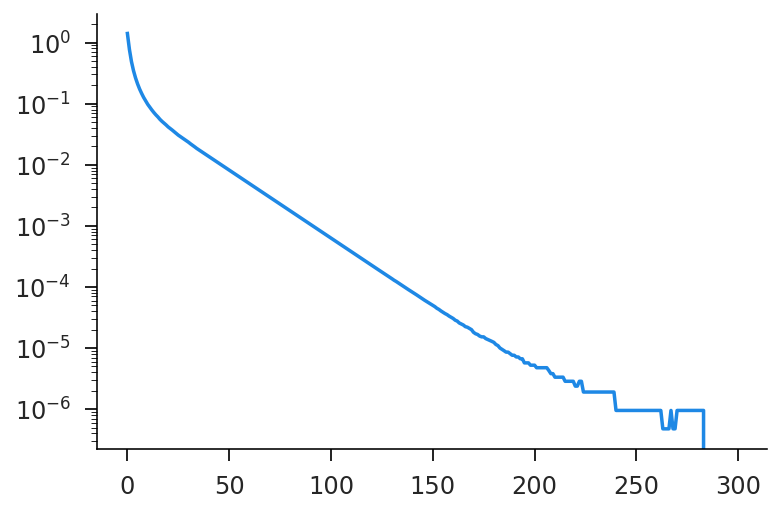

In [15]:
plt.plot(ret['err'])
plt.yscale('log');

### Pure Numpy

In [16]:
# pure numpy grid
k_grid0 = np0.linspace(k_min, k_max, N)

In [17]:
def solve_numpy(par):
    # get params
    z, α, δ = par['z'], par['α'], par['δ']

    # precompute grid values
    y_grid0 = prod(k_grid0, z, α)
    yd_grid0 = y_grid0 + (1-δ)*k_grid0
    cp_grid0 = yd_grid0[:,None] - k_grid0[None,:]

    # store history
    v_path = np.zeros((T, N))
    err = np.zeros(T)

    # call value directly
    grid0 = {'cp': cp_grid0}
    st0 = {'vn': util(y_grid0, np=np0)}
    tv0 = {}
    for t in range(T):
        stp0, _ = value(par0, grid0, st0, tv0, np=np0)
        err[t] = np.max(np.abs(stp0['vn']-st0['vn']))
        st0 = {'vn': stp0['vn']}
        v_path[t, :] = stp0['vn']

    return {'v': v_path, 'err': err}

In [23]:
%time ret = solve_numpy(par0)

CPU times: user 1.12 s, sys: 199 ms, total: 1.32 s
Wall time: 971 ms


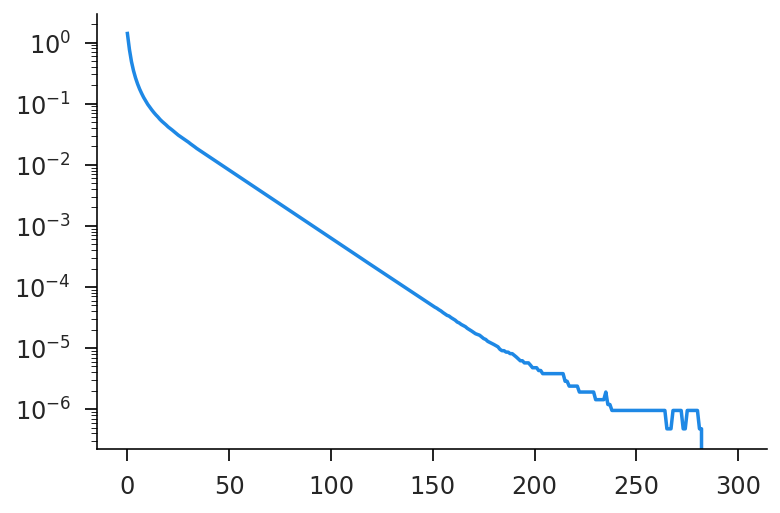

In [19]:
plt.plot(ret['err'])
plt.yscale('log');